# Read downloaded csv

In [1]:
%cd ../

/workspaces/formula1-season-explorer


In [2]:
import os
from datetime import timedelta

import numpy as np
import pandas as pd

from modules.model.past_data_retriever import load_csv_data
from modules.utils import load_config

BUCKET_NAME = os.environ.get('BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
DICT_CONFIG = load_config("./config/config.yml")

In [3]:
df_qualifying = load_csv_data(data_name="qualifying", bucket_name=BUCKET_NAME, aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY, s3_past_data_key=DICT_CONFIG["s3_past_data_key"])
df_results = load_csv_data(data_name="results", bucket_name=BUCKET_NAME, aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY, s3_past_data_key=DICT_CONFIG["s3_past_data_key"])
df_races = load_csv_data(data_name="races", bucket_name=BUCKET_NAME, aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY, s3_past_data_key=DICT_CONFIG["s3_past_data_key"])
df_drivers = load_csv_data(data_name="drivers", bucket_name=BUCKET_NAME, aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY, s3_past_data_key=DICT_CONFIG["s3_past_data_key"])

# Make datamart
- When doing inference (prediction by pretrained model), ergast api is used to make datamart

In [4]:
# merge dfs into one

df = pd.merge(
    df_results.loc[
        :, 
        [
            "raceId", 
            "driverId", 
            "positionOrder", 
        ]
    ], 
    df_qualifying.loc[
        :,
        [
            "raceId",
            "driverId",
            "q1",
            "q2",
            "q3",
        ]
    ], 
    on=[
        "raceId", 
        "driverId", 
    ], 
    how="left", 
    suffixes=["_race", "_qualify"]
)
df = pd.merge(
    df, 
    df_races.loc[
        :,
        [
            "raceId", 
            "year", 
            "round", 
            "name", 
        ]
    ], 
    on="raceId",
    how="left"
)
df = pd.merge(df, df_drivers.loc[:, ["driverId", "driverRef"]], on="driverId", how="left")

df.drop(
    columns=[
        "raceId", 
        "driverId",
    ], 
    inplace=True
)

df.replace({"\\N": np.nan}, inplace=True)
df.reset_index(drop=True, inplace=True)
df.rename(
    columns={
        "name": "grandprix",
        "positionOrder": "position",
        "driverRef": "driver",
    },
    inplace=True
)

In [5]:
# convert string to seconds

def cvt_qualifytime_to_sec(str_time: str):
    """Convert string as a format of minute:second.millsecond to sec"""
    try:
        minutes, seconds = str_time.split(":")
        seconds, milliseconds = seconds.split(".")
        time = timedelta(minutes=int(minutes), seconds=int(seconds), milliseconds=int(milliseconds))
        return time.total_seconds()
    except:
        return np.nan

for qualify_round in range(1, 4):
    df[f"q{qualify_round}"] = df[f"q{qualify_round}"].apply(cvt_qualifytime_to_sec)

In [6]:
df.head()

,position,q1,q2,q3,year,round,grandprix,driver
0,1,86.572,85.187,86.714,2008,1,Australian Grand Prix,hamilton
1,2,85.960,85.518,87.236,2008,1,Australian Grand Prix,heidfeld
2,3,86.295,86.059,88.687,2008,1,Australian Grand Prix,rosberg
3,4,86.907,86.188,NaN,2008,1,Australian Grand Prix,alonso
4,5,85.664,85.452,87.079,2008,1,Australian Grand Prix,kovalainen


# Preprocess
- The process below is the same as preprocess of inference

In [7]:
from modules.model.preprocess import make_model_input_data

In [8]:
model_input_data = make_model_input_data(df)

# Classifier

## Train model

In [9]:
from modules.model.model import Classifier

In [10]:
data_train = model_input_data.df.loc[model_input_data.df["year"] < 2023]
data_test = model_input_data.df.loc[model_input_data.df["year"] >= 2023]

X_train = data_train.loc[:, model_input_data.list_col_X]
X_test = data_test.loc[:, model_input_data.list_col_X]
y_train = data_train[model_input_data.col_y] == 1
y_test = data_test[model_input_data.col_y] == 1

In [11]:
classifier = Classifier(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)
classifier.train(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Number of positive: 1082, number of negative: 24758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 25840, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.944262


In [12]:
y_pred = classifier.predict(X_test)

## Evaluate
- Adhoc check of trained models
- This is only in notebook

In [13]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

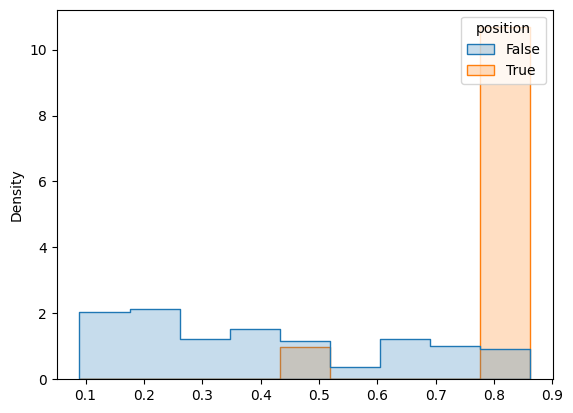

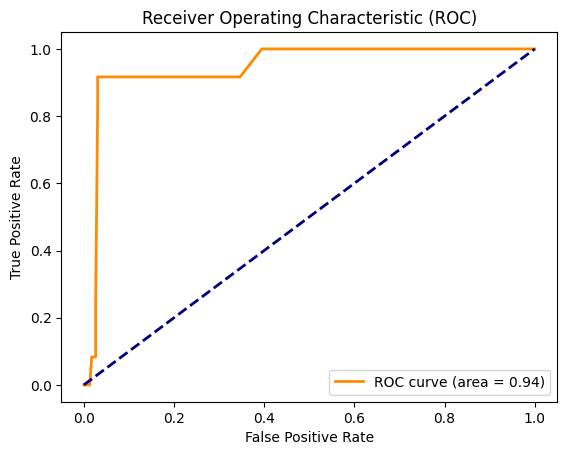

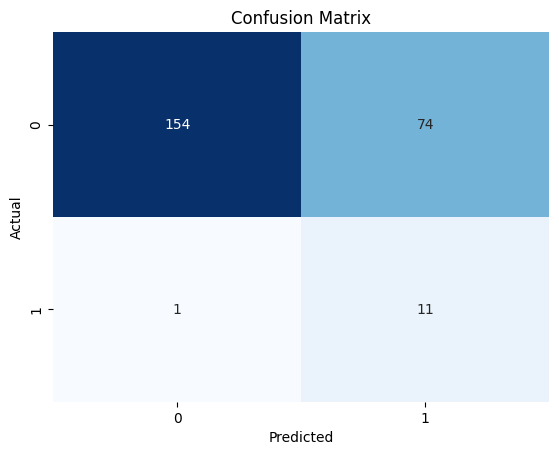

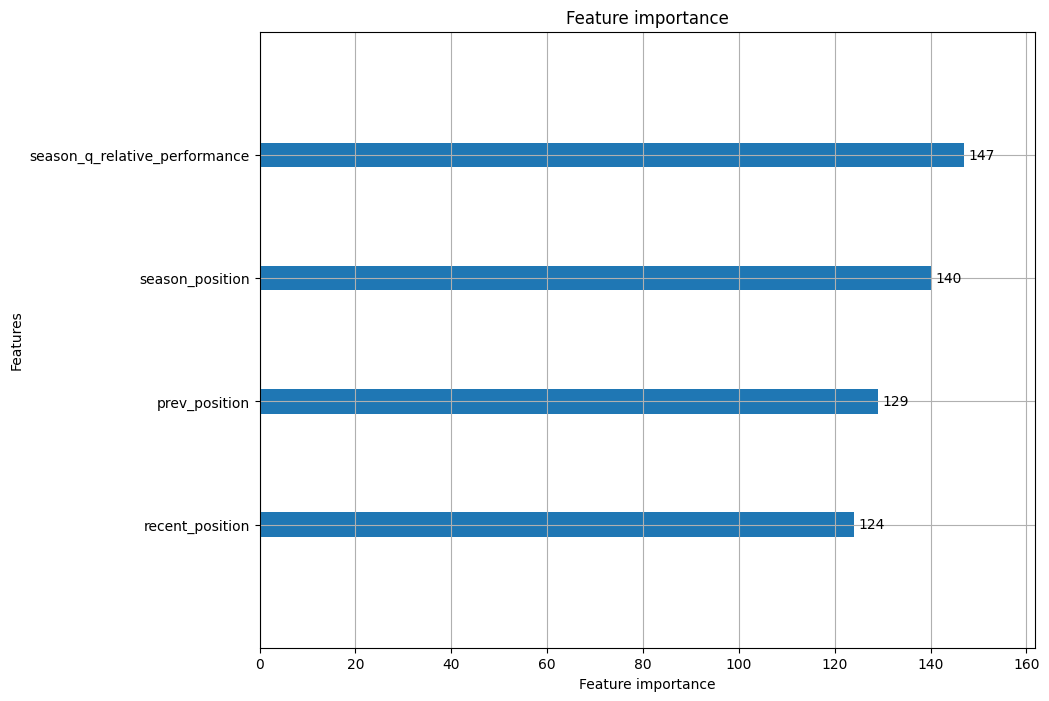

In [14]:
# How well the model is predicting
sns.histplot(x=y_pred, hue=y_test, element="step", stat="density", common_norm=False)


# Area Under the Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
matrix = confusion_matrix(y_test, np.round(y_pred))

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
lgb.plot_importance(classifier.model, figsize=(10, 8))
plt.show()

## Save model to S3

In [15]:
classifier.save_model()

## Load model from S3 and Predict

In [16]:
classifier_2 = Classifier(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)

classifier_2.load_model()

y_pred_2 = classifier_2.predict(X_test)

# Ranker

## Train

In [17]:
from modules.model.model import Ranker

In [18]:
model_input_data.df.sort_values(by=["year", "round"], inplace=True)

data_train = model_input_data.df.loc[model_input_data.df["year"] < 2023]
data_test = model_input_data.df.loc[model_input_data.df["year"] >= 2023]

X_train = data_train[model_input_data.list_col_X]
X_test = data_test[model_input_data.list_col_X]
# Start from 0 and clip to 19 (predict rank from 1 to 20)
y_train= (data_train[model_input_data.col_y]-1).clip(upper=19) 
y_test = (data_test[model_input_data.col_y]-1).clip(upper=19)

# Make query
query_train = data_train.groupby(["year", "round"]).size().to_numpy()
query_test = data_test.groupby(["year", "round"]).size().to_numpy()

In [19]:
ranker = Ranker(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)

ranker.train(X_train, X_test, y_train, y_test, query_train, query_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 25840, number of used features: 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	valid_0's ndcg@1: 0.317219	valid_0's ndcg@3: 0.294014	valid_0's ndcg@10: 0.423438


In [20]:
y_pred = ranker.predict(X_test, query_test)

## Evaluate

In [21]:
import seaborn as sns
from sklearn.metrics import ndcg_score
from scipy import stats

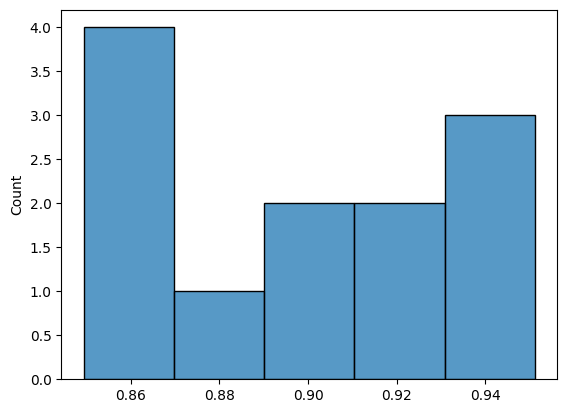

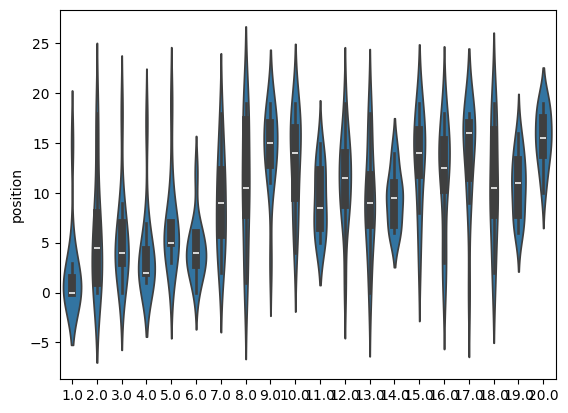

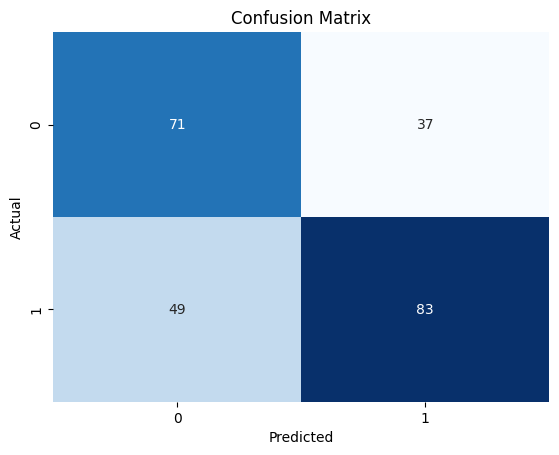

In [23]:
# NDCG distribution for each query
ndcg = []
for idx, query in enumerate(query_test):
    ndcg.append(ndcg_score(y_test.iloc[idx * query: (idx + 1) * query].values.reshape(1, -1), y_pred[idx * query: (idx + 1) * query].reshape(1, -1)))
sns.histplot(ndcg)
plt.show()

# Relation between prediction and position
sns.violinplot(x=y_pred, y=y_test)
plt.show()


# Confusion Matrix for top 10
matrix = confusion_matrix(y_test<=10, y_pred<=10)
plt.figure()
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Save model to S3

In [24]:
ranker.save_model()

## Load model and predict

In [25]:
ranker_2 = Ranker(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)

ranker_2.load_model()

In [26]:
# If you predict only a round, query is not needed for predict
y_pred_2 = ranker_2.predict(X_test.iloc[-20:])

In [27]:
y_pred_2

array([16,  4,  9, 14,  3, 13, 19,  8,  1,  6, 10,  5, 15, 17,  7,  2, 20,
       11, 18, 12])